## Coastline Changes

By Jon, Damian and Martyna

## Instructions

First create an Anaconda environment and install geemap:

conda create -n gee python

conda activate gee

conda install mamba -c conda-forge

mamba install geemap -c conda-forge


In [16]:
import os
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2
import easygui

In [8]:
Map = geemap.Map(center=(25, 55), zoom=11)
Map

Map(center=[25, 55], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=Fa…

#### Earth Engine map contained within Python

In [11]:
# Landsat 5 collecton surface reflection (March 1984 - May 2012)
# LANDSAT/LT05/C01/T1_SR
    
# Landsat 8 collection surface reflection(April 2013 - Present)
# LANDSAT/LC08/C01/T1_SR

collections = {
    'landsat5': 'LANDSAT/LT05/C01/T1_SR',
    'landsat8': 'LANDSAT/LC08/C01/T1_SR'} 

# Select collection
chosenCollection = collections['landsat5']

# landsatCollection = ee.ImageCollection(chosenCollection)
# regionOfInterestPoint = ee.Geometry.Point(55, 25)
areaOfInterest = landsatCollection.filterBounds(regionOfInterestPoint)

if chosenCollection == 'LANDSAT/LT05/C01/T1_SR':
    print("Landsat 5 Collection Chosen")
    landsat = landsatCollection.filterDate('1984-01-01', '1984-12-31')
    
elif chosenCollection == 'LANDSAT/LC08/C01/T1_SR':
    print("Landsat 8 Collection Chosen")
    landsat = landsatCollection.filterDate('2018-01-01', '2018-12-31')

leastCloudyImage = ee.Image(areaOfInterest.sort('CLOUD_COVER').first())


print('Total number:', areaOfInterest.size().getInfo())
print(leastCloudyImage.get('CLOUD_COVER').getInfo())

visualParams = {
    'min': 0,
    'max': 5000,
    'bands': ['B4', 'B3', 'B2']
}

Map.addLayer(leastCloudyImage, visualParams)

Landsat 5 Collection Chosen
Total number: 316
0


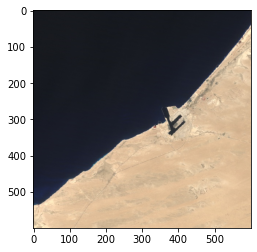

In [26]:
# Crop the region from a full screenshot
easygui.msgbox("Pick the image you want to crop")
imageFilePath = easygui.fileopenbox(filetypes=["*.jpg","*.jpeg","*.png"])

I = cv2.imread(imageFilePath)
h, w, d = I.shape

cropSizeFromCentre = (600, 600)
x = int(w/2)
y = int(h/2)
pt1 = (x - int(cropSizeFromCentre[0]/2), y - int(cropSizeFromCentre[1]/2))
pt2 = (x + int(cropSizeFromCentre[0]/2), y + int(cropSizeFromCentre[1]/2))

croppedImage = I[pt1[1] : pt2[1], pt1[0] : pt2[0]]

# Write image to a file
imageFileName = re.search("([^\\\]*$)", imageFilePath).group(0)
if imageFileName == None:
    imageFileName = "CroppedImage.png"
    
newFileName = "Cropped"+imageFileName
cv2.imwrite(newFileName, croppedImage)

plt.imshow(cv2.cvtColor(croppedImage, cv2.COLOR_BGR2RGB))